In [145]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import ot
import ot.plot
from scipy.misc import derivative
from scipy.spatial.distance import cdist
import pandas as pd
import os

#### sorted by wasserstein distance
[10 15 25 20 30 35 40 45 50]

In [173]:
# load data
soc5 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-045.xlsx', engine='openpyxl').values
soc10 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-050.xlsx', engine='openpyxl').values
label = pd.read_excel('/Users/liuhanbing/Desktop/code/cdot/source.xlsx', engine='openpyxl').values

soc5_xs = soc5[:, 2 : 23] # (67, 21)
soc5_ys = soc5[:, 1] # (67, )
# soc5_ys = label[:, 1]

soc10_xt = soc10[:, 2 : 23] # (67, 21)
soc10_yt = soc10[:, 1] # (67, )

# sort = np.random.choice(range(soc10_xt.shape[0]), 10, False)
# soc10_xt = soc10_xt[sort]
# soc10_yt = soc10_yt[sort]

# soc5_xs = soc5_xs[sort]
# soc5_ys = label[:, 1]


In [174]:
# loss matrix
M = ot.dist(soc5_xs, soc10_xt, metric='euclidean') 
M /= M.max() # (67, 67)
n1 = soc5_xs.shape[0]
n2 = soc10_xt.shape[0]
a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2  # uniform distribution on samples
print(M.shape)
print(n1, n2)

(67, 67)
67 67


In [175]:
lambd = 0.01
max_epoch = 10
step_size = 0.001
mut = 50

In [176]:
gamma0 = ot.sinkhorn(a, b, M, lambd) # (67, 67)
print(gamma0)
print(gamma0.shape)
def derivation(gamma):
    tmp1 = 2 * (n2 ** 2) * soc5_xs @ soc5_xs.T @ gamma
    
    tmp2 = (n1 * n2) * soc5_xs @ soc0_x.T @ gamma_t0
    return tmp1 - 2 * tmp2


[[4.95129780e-04 2.91328409e-04 1.86255734e-04 ... 1.35857993e-04
  9.38011570e-05 9.17568979e-05]
 [4.92189529e-04 2.91461647e-04 1.86951509e-04 ... 1.35767375e-04
  9.30249873e-05 9.03637005e-05]
 [4.93720367e-04 3.08199139e-04 1.99480648e-04 ... 1.44780573e-04
  9.87590978e-05 9.54997453e-05]
 ...
 [4.24830581e-15 3.39885904e-09 4.00554526e-04 ... 3.03302542e-04
  2.03791101e-04 1.94670389e-04]
 [3.99215330e-28 3.04147194e-22 9.09014767e-12 ... 7.73309160e-04
  5.73754702e-04 5.54712618e-04]
 [9.66730678e-32 7.20221231e-26 2.12066582e-15 ... 5.78015188e-04
  8.30978865e-04 8.21144250e-04]]
(67, 67)


In [168]:
gamma = np.random.rand(n1, n2)
for i in range(max_epoch):
    c = step_size * M + step_size * mut * derivation(gamma) - np.log(gamma)
    c /= c.max()
    gamma = ot.sinkhorn(a, b, c, 1+step_size*lambd)

# gamma = gamma0

print(gamma)


ValueError: operands could not be broadcast together with shapes (67,67) (67,10) 

In [179]:
xt = n1 * gamma.dot(soc10_xt)
print(xt.shape)
# yt = n1 * gamma.T.dot(soc5_ys)
# loss = np.mean(np.square(yt - soc10_yt))

# pl.plot(soc5_xs[0, :], '+b', label='Source samples')
# pl.plot(xt[0, :], 'xr', label='Transported samples')
# # pl.plot(soc10_xt[0, :], '+g', label='Target samples')
# pl.legend(loc=0)
# pl.title('OT matrix Sinkhorn with samples')

(67, 21)


Text(0.5, 1.0, 'OT matrix sinkhorn')

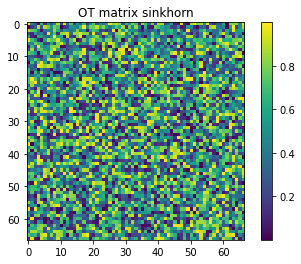

In [180]:
pl.figure(5)

pl.imshow(gamma, interpolation='nearest')
pl.colorbar()

pl.title('OT matrix sinkhorn')

# pl.figure(6)
# ys = np.expand_dims(soc5_ys, axis = 1)
# yt = np.expand_dims(soc10_yt, axis = 1)

# x = np.arange(n1)

# ot.plot.plot2D_samples_mat(soc5_xs, soc10_xt, gamma, color=[.5, .5, 1])
# pl.plot(x, ys, '+b', label='Source samples')
# pl.plot(x, yt, 'xr', label='Target samples')
# pl.legend(loc=0)
# pl.title('OT matrix Sinkhorn with samples')
# pl.show()


In [181]:
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.metrics import r2_score
model_SVR = svm.SVR()
model_RandomForestRegressor = ensemble.RandomForestRegressor(n_estimators=4)
from sklearn import neighbors
model_KNeighborsRegressor = neighbors.KNeighborsRegressor()

score = 0
def try_different_method(model):
    model.fit(xt, soc5_ys)
    # score = model.score(soc10_xt, soc10_yt)
    result = model.predict(soc10_xt)
    score = r2_score(result, soc10_yt)
    loss = np.mean(np.square(result - soc10_yt))
    print("score ", score)
    print("loss ", loss)

    return result, loss, score

result, loss, score = try_different_method(model_RandomForestRegressor)
minloss = loss
bestresult = result
ascore = score

for i in range(9):  
    result, loss, score = try_different_method(model_RandomForestRegressor)
    if(loss < minloss):
        minloss = loss
        bestresult = result
        ascore = score
        
print("model score ", ascore)
print("min loss ", minloss)

data = pd.DataFrame(bestresult)

writer = pd.ExcelWriter('source.xlsx')
data.to_excel(writer, 'page_1', float_format='%.5f')
writer.save()

writer.close()


score  0.8728469035552616
loss  0.004941878466791039
score  0.8654490032190243
loss  0.005062177621268653
score  0.8648269161082506
loss  0.005567582245802235
score  0.858395019121637
loss  0.005878165335820896
score  0.8692335483897995
loss  0.005343973691044776
score  0.8799404890757929
loss  0.004574170279850747
score  0.8673762700568246
loss  0.004642689143493472
score  0.8736676535515898
loss  0.004625689113805967
score  0.8725676989038529
loss  0.004874723703171643
score  0.8673773411476828
loss  0.005528609225746268
model score  0.8799404890757929
min loss  0.004574170279850747


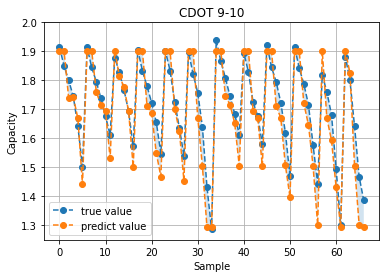

In [182]:
y = np.zeros((67,1))
y[:,0] = soc10_yt[:]
plt.figure()
plt.plot(y,'o--',label='true value')
plt.plot(bestresult,'o--',label='predict value')

plt.grid()
plt.title('score: %f'%score)

plt.title('CDOT 9-10')
plt.xlabel('Sample')
plt.ylabel('Capacity')
plt.legend()
plt.fill_between(np.arange(67), bestresult.squeeze(), y.squeeze(), alpha=0.2)
plt.ylim([1.25, 2])
plt.show()


In [183]:
soc0_x = soc5_xs
gamma_t0 = gamma

Text(0, 0.5, 'loss')

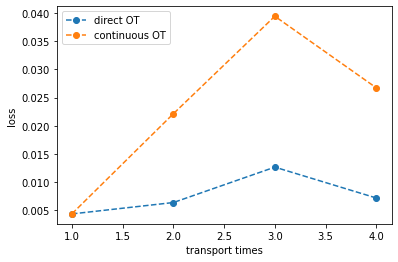

In [186]:
x = np.arange(4) + 1
ls = []
seq_ls = []

pt = "/Users/liuhanbing/Desktop/code/cdot/log.txt"
with open(pt) as f:
    lines = f.readlines()
for line in lines:
    seq = line.split('\t')
    ls.append(float(seq[0]))

pt = "/Users/liuhanbing/Desktop/code/cdot/seq-log.txt"
with open(pt) as f:
    lines = f.readlines()
for line in lines:
    seq = line.split('\t')
    seq_ls.append(float(seq[0]))

plt.figure()
plt.plot(x, ls,'o--',label='direct OT')
plt.plot(x, seq_ls,'o--',label='continuous OT')
plt.legend()
plt.xlabel('transport times')
plt.ylabel('loss')

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [ ]:
# load data
soc05 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-005.xlsx', engine='openpyxl').values
soc10 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-010.xlsx', engine='openpyxl').values
soc15 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-015.xlsx', engine='openpyxl').values
soc20 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-020.xlsx', engine='openpyxl').values
soc25 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-025.xlsx', engine='openpyxl').values
soc30 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-030.xlsx', engine='openpyxl').values
soc35 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-035.xlsx', engine='openpyxl').values
soc40 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-040.xlsx', engine='openpyxl').values
soc45 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-045.xlsx', engine='openpyxl').values
soc50 = pd.read_excel('/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/out-SOC-050.xlsx', engine='openpyxl').values

soc05_x = soc05[:, 2 : 23]
soc10_x = soc10[:, 2 : 23]
soc15_x = soc15[:, 2 : 23]
soc20_x = soc20[:, 2 : 23]
soc25_x = soc25[:, 2 : 23]
soc30_x = soc30[:, 2 : 23]
soc35_x = soc35[:, 2 : 23]
soc40_x = soc40[:, 2 : 23]
soc45_x = soc45[:, 2 : 23]
soc50_x = soc50[:, 2 : 23]


In [ ]:
n1 = soc5_xs.shape[0]
n2 = soc10_xt.shape[0]
a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2  # uniform distribution on samples

In [ ]:
M1 = ot.dist(soc05_x, soc10_x, metric='euclidean') 
M2 = ot.dist(soc05_x, soc15_x, metric='euclidean') 
M3 = ot.dist(soc05_x, soc20_x, metric='euclidean') 
M4 = ot.dist(soc05_x, soc25_x, metric='euclidean') 
M5 = ot.dist(soc05_x, soc30_x, metric='euclidean') 
M6 = ot.dist(soc05_x, soc35_x, metric='euclidean') 
M7 = ot.dist(soc05_x, soc40_x, metric='euclidean') 
M8 = ot.dist(soc05_x, soc45_x, metric='euclidean') 
M9 = ot.dist(soc05_x, soc50_x, metric='euclidean') 

M1 /= M1.max()
M2 /= M2.max()
M3 /= M3.max()
M4 /= M4.max()
M5 /= M5.max()
M6 /= M6.max()
M7 /= M7.max()
M8 /= M8.max()
M9 /= M9.max()

In [ ]:
w_dist = []
for i in range(9):
    m = "M{}".format(i+1)
    m = eval(m)
    c = ot.sinkhorn2(a, b, m, 1)
    w_dist.append(c[0])
print(w_dist)
argod = np.argsort(w_dist)
print(argod*5 + 10)

[0.5019350078619227, 0.6377090878666845, 0.6822332909735622, 0.6750964638103856, 0.6899762167676761, 0.7403314935178459, 0.789953418846622, 0.8194369657034292, 0.8280240958202888]
[10 15 25 20 30 35 40 45 50]


Text(0, 0.5, 'W-distance')

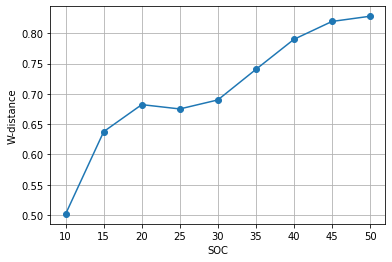

In [ ]:
x = np.arange(10, 55, 5)
plt.plot(x, w_dist, 'o-')
plt.grid()
plt.xlabel('SOC')
plt.ylabel('W-distance')


In [ ]:
pca.fit(soc05_x)
X05 = pca.transform(soc05_x) 

pca.fit(soc10_x)
X10 = pca.transform(soc10_x) 

pca.fit(soc15_x)
X15 = pca.transform(soc15_x) 

pca.fit(soc20_x)
X20 = pca.transform(soc20_x)

pca.fit(soc25_x)
X25 = pca.transform(soc25_x)

pca.fit(soc30_x)
X30 = pca.transform(soc30_x)

pca.fit(soc35_x)
X35 = pca.transform(soc35_x)

pca.fit(soc40_x)
X40 = pca.transform(soc40_x)

pca.fit(soc45_x)
X45 = pca.transform(soc45_x)

pca.fit(soc50_x)
X50 = pca.transform(soc50_x)

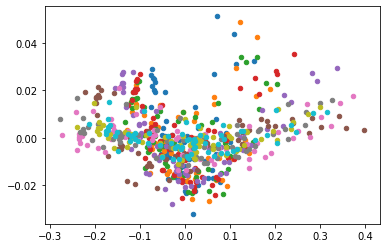

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
# ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
# ax = Axes3D(fig)
# ax.scatter(X05[:, 0],X05[:, 1],X05[:, 2])
# ax.scatter(X10[:, 0],X10[:, 1],X10[:, 2])
# ax.scatter(X15[:, 0],X15[:, 1],X15[:, 2])
# ax.scatter(X20[:, 0],X20[:, 1],X20[:, 2])
# ax.scatter(X25[:, 0],X25[:, 1],X25[:, 2])
# ax.scatter(X30[:, 0],X30[:, 1],X30[:, 2])
# ax.scatter(X35[:, 0],X35[:, 1],X35[:, 2])
# ax.scatter(X40[:, 0],X40[:, 1],X40[:, 2])
# ax.scatter(X45[:, 0],X45[:, 1],X45[:, 2])
# ax.scatter(X50[:, 0],X50[:, 1],X50[:, 2])



plt.scatter(X05[:, 0], X05[:, 1], marker='o', s=20)
plt.scatter(X10[:, 0], X10[:, 1], marker='o', s=20)
plt.scatter(X15[:, 0], X15[:, 1], marker='o', s=20)
plt.scatter(X20[:, 0], X20[:, 1], marker='o', s=20)
plt.scatter(X25[:, 0], X25[:, 1], marker='o', s=20)
plt.scatter(X30[:, 0], X30[:, 1], marker='o', s=20)
plt.scatter(X35[:, 0], X35[:, 1], marker='o', s=20)
plt.scatter(X40[:, 0], X40[:, 1], marker='o', s=20)
plt.scatter(X45[:, 0], X45[:, 1], marker='o', s=20)
plt.scatter(X50[:, 0], X50[:, 1], marker='o', s=20)

plt.show()


### kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=3, kernel='rbf', gamma=30)

In [ ]:
kpca.fit(soc05_x)
X05 = kpca.transform(soc05_x) 

kpca.fit(soc10_x)
X10 = kpca.transform(soc10_x) 

kpca.fit(soc15_x)
X15 = kpca.transform(soc15_x) 

kpca.fit(soc20_x)
X20 = kpca.transform(soc20_x)

kpca.fit(soc25_x)
X25 = kpca.transform(soc25_x)

kpca.fit(soc30_x)
X30 = kpca.transform(soc30_x)

kpca.fit(soc35_x)
X35 = kpca.transform(soc35_x)

kpca.fit(soc40_x)
X40 = kpca.transform(soc40_x)

kpca.fit(soc45_x)
X45 = kpca.transform(soc45_x)

kpca.fit(soc50_x)
X50 = kpca.transform(soc50_x)

In [ ]:
X05 == X15

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [Fal

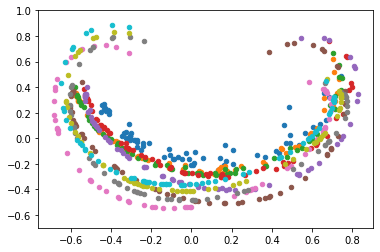

In [ ]:
plt.ylim([-0.7, 1])
plt.scatter(X05[:, 0], X05[:, 1], marker='o', s=20)
plt.scatter(X10[:, 0], X10[:, 1], marker='o', s=20)
plt.scatter(X15[:, 0], X15[:, 1], marker='o', s=20)
plt.scatter(X20[:, 0], X20[:, 1], marker='o', s=20)
plt.scatter(X25[:, 0], X25[:, 1], marker='o', s=20)
plt.scatter(X30[:, 0], X30[:, 1], marker='o', s=20)
plt.scatter(X35[:, 0], X35[:, 1], marker='o', s=20)
plt.scatter(X40[:, 0], X40[:, 1], marker='o', s=20)
plt.scatter(X45[:, 0], X45[:, 1], marker='o', s=20)
plt.scatter(X50[:, 0], X50[:, 1], marker='o', s=20)

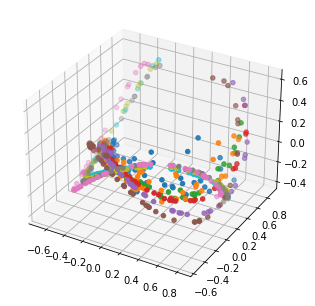

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X05[:, 0],X05[:, 1],X05[:, 2])
ax.scatter(X10[:, 0],X10[:, 1],X10[:, 2])
ax.scatter(X15[:, 0],X15[:, 1],X15[:, 2])
ax.scatter(X20[:, 0],X20[:, 1],X20[:, 2])
ax.scatter(X25[:, 0],X25[:, 1],X25[:, 2])
ax.scatter(X30[:, 0],X30[:, 1],X30[:, 2])
ax.scatter(X35[:, 0],X35[:, 1],X35[:, 2])
ax.scatter(X40[:, 0],X40[:, 1],X40[:, 2])
ax.scatter(X45[:, 0],X45[:, 1],X45[:, 2])
ax.scatter(X50[:, 0],X50[:, 1],X50[:, 2])

plt.show()